In [2]:
import pandas as pd
import datetime
import numpy as np
import geopy.distance
import glob, os
import matplotlib.pyplot as plt
from matplotlib import animation

def normalize(df):    
    return (df - df.min()) / (df.max() - df.min())


def denormalize(df,norm_data):    
    return (norm_data * (df.max() - df.min())) + df.min()

def parseSlot(df):
    data = np.array(df[['counts_norm', 'bgCounts_norm']].values)
    return np.ndarray.flatten(data)

def getDate(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp))

def calTimeSpan(df):
    stop = getDate(dict(df.iloc[1])['datetime'])
    start = getDate(dict(df.iloc[-1])['datetime'])
    return start, stop

def getSweepSlots(start, stop, windowInHours = 5 * 24, shiftRateInHours = 1):
    delta = datetime.timedelta(hours=windowInHours)
    shift = datetime.timedelta(hours=shiftRateInHours)
    spanDelta = stop - start
    slots = int(spanDelta/shift)
    SweepSlots = []
    for slot in range(slots):
        SweepSlots.append([start + slot*shift, start + slot*shift + delta])
    return SweepSlots

def selectSweepData(df, slots):
    dSlots = []
    for slot in slots:
        start = slot[0].timestamp()
        stop  = slot[1].timestamp()
        #print(start, stop)
        dSlots.append({'start': start, 'stop': stop, 'data': df.loc[(df['datetime'] > start) & (df['datetime'] < stop)]})
    return dSlots

def filterBadSweeps(dSlots, dataPerSlot):
    newDSlots = []
    for dslot in dSlots:
        if len(dslot['data']) == dataPerSlot:
            newDSlots.append({'start': dslot['start'], 'stop': dslot['stop'], 'data': parseSlot(dslot['data'])})
    return newDSlots

def selectEventInSlot(eventdf, dSlots, eventMaxDistInKM, site, eventWindowInHours):
    #print(eventdf)
    for dSlot in dSlots:
        start = dSlot['stop']
        stop  = dSlot['stop'] + eventWindowInHours * 60 * 60
        events = eventdf.loc[(eventdf['datetime'] > start) &
                           (eventdf['datetime'] < stop)]
        #print(len(selectNearby(events, eventMaxDistInKM, site)))
        dSlot['output'] = len(selectNearby(events, eventMaxDistInKM, site)) > 0
    return dSlots

def selectNearby(eventdf, eventMaxDistInKM, site):
    siteCoords = (site['lat'], site['lng'])
    newEventDf = []
    for index, row in eventdf.iterrows():
        event = dict(row)
        eventCoords = (event['Latitude'], event['Longitude'])
        distance = geopy.distance.vincenty(siteCoords, eventCoords).km
        if distance <= eventMaxDistInKM:
            newEventDf.append(event)
    return pd.DataFrame(newEventDf)

def toDateTime(timeString):
    return datetime.datetime.strptime(timeString, '%d/%m/%Y %H:%M:%S').timestamp()

def finalize(eventDSlots):
    finalData = []    
    for eventDSlot in eventDSlots:
        data = {}
        inputData = eventDSlot['data']
        for i,j in enumerate(inputData):
            data[i] = j
        data['out'] = eventDSlot['output']
        finalData.append(data)
    return pd.DataFrame(finalData)

def NomMerge(fileNames, outFile):
    frames = []
    for fileName in fileNames:
        df = pd.read_csv(fileName, index_col=None, header=0)
        df.dropna(inplace=True)
        df_out = df['out']
        df_nom = normalize(df.drop(['out'],axis=1))
        df_nom['out']=df_out
        frames.append(df_nom)
    frame = pd.concat(frames)
    frame.to_csv(outFile, index=False)
    pass

def merge(fileNames, outFile):
    frames = []
    for fileName in fileNames:
        df = pd.read_csv(fileName, index_col=None, header=0)
        df['out']=df['out']*1
        df = df.dropna(inplace=False)
        msk = np.random.rand(len(df)) < 1
        df = df[msk]      
        frames.append(df)
    frame = pd.concat(frames)
    frame.to_csv(outFile, index=False)
    pass

def animateGraph(fileName):
    df = pd.read_csv(fileName)
    eventDf = df['out']
    predDf = df['pred']
    df= df.drop('out', axis=1)
    df= df.drop('pred', axis=1)
    dataList = df.values 
    length = len(dataList[0])
    dlen = len(dataList)-1
    #dlen = 100
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_ylim((-0.2, 1))
    for i in range(5):
        ax.axvline(x=192*i, color='blue')
    for i in range(5, 8):
        ax.axvline(x=192*i, color='red')

    x = range(length)
    y = dataList[0]
    line, = ax.plot(x, y)
    #text = ax.text(0, 0.3, "Event: True",  bbox=dict(facecolor='white', alpha=0.5))
    eventTxt = ax.text(192*5, 0.3, "")
    predTxt = ax.text(192*5, 0.2, "")

    def init():    
        line.set_data([], [])
        eventTxt = ax.text(192*5, 0.3, "")
        predTxt = ax.text(192*5, 0.2, "")
        return (line, eventTxt, predTxt, )

    def animate(i):
        if not i % 100:
            print(i)
        y = dataList[dlen-i]
        line.set_data(x, y)
        if eventDf[dlen-i]:
            eventTxt.set_text("Event: {0}".format('True'))
            eventTxt.set_bbox(dict(facecolor='red', alpha=0.5))
        else:
            eventTxt.set_text("Event: {0}".format('False'))
            eventTxt.set_bbox(dict(facecolor='blue', alpha=0.5))
        if predDf[dlen-i]:
            predTxt.set_text("Prediction: {0}".format('True'))
            predTxt.set_bbox(dict(facecolor='red', alpha=0.5))
        else:
            predTxt.set_text("Prediction: {0}".format('False'))
            predTxt.set_bbox(dict(facecolor='blue', alpha=0.5))
        return (line, eventTxt, predTxt, )

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=dlen, interval=20, blit=True)
    anim.save(fileName + '.mp4')
    HTML(anim.to_html5_video())

In [3]:
%matplotlib inline

In [4]:
sites = [#{'site':'BARC',                       'lat':19.0436,  'lng':72.9197, 'srNo':},
         {'site':'Aggarwal College Ballabgarh', 'lat':28.3317,  'lng':77.3344, 'srNo': 1613},
         {'site':'Gauhati University',          'lat':26.1551,  'lng':91.6627, 'srNo': 1629},
         {'site':'GZRSC, Aizawl',               'lat':23.7398,  'lng':92.7223, 'srNo': 1617},
         #{'site':'IIG Vizag',                  'lat':17.68,    'lng':83.32,   'srNo':},
         {'site':'IOP Bhubaneshwar',            'lat':20.3091,  'lng':85.8309, 'srNo': 1631},
         {'site':'Kashmir University',          'lat':34.12796, 'lng':74.8365, 'srNo': 1622},
         {'site':'Manipur University',          'lat':24.7507,  'lng':93.9291, 'srNo': 1612},
         {'site':'Mizoram University',          'lat':23.735,   'lng':92.6671, 'srNo': 1614},
         {'site':'Nagaland University',         'lat':25.7247,  'lng':94.0955, 'srNo': 1615},
         {'site':'NEHU Shillong',               'lat':25.6089,  'lng':91.8999, 'srNo': 1630},
         {'site':'NIT Rourkela',                'lat':22.2533,  'lng':84.9011, 'srNo': 1601},
         {'site':'SGRC Shillong',               'lat':25.61,    'lng':91.896,  'srNo': 1512},
         {'site':'Silchar Assam',               'lat':24.6919,  'lng':92.7503, 'srNo': 1607},
         {'site':'SINP Kolkata',                'lat':22.5997,  'lng':88.42,   'srNo': 1627},
         {'site':'IIT Roorkee',                 'lat':29.8649,  'lng':77.8966, 'srNo': 1610},
        ]

In [8]:
windowInHours = 10 * 24
shiftRateInHours = 1
dataPerSlot = 960
eventWindowInHours = 2 * 24
eventMaxDistInKM = 500 # 1000 is too far

eventdf = pd.read_csv('data/events.csv')
eventdf['datetime'] = eventdf['DateTime(IST)'].apply(lambda x: toDateTime(x))
fileNames = []
for site in sites[:2]:
    selectedSite = site['srNo']
    df = pd.read_csv('data/sites/'+str(selectedSite)+'.csv')
    start, stop = calTimeSpan(df)
    SweepSlots = getSweepSlots(start, stop, windowInHours = windowInHours)
    #print(len(SweepSlots))
    dSlots = filterBadSweeps(selectSweepData(df, SweepSlots), dataPerSlot)
    #print(len(dSlots))
    
    eventDSlots = selectEventInSlot(eventdf, dSlots, eventMaxDistInKM, site, eventWindowInHours)
    finalData = finalize(eventDSlots)
    fileName = 'data/finalData/'+str(selectedSite)+'.csv'
    finalData.to_csv(fileName, index=False)    
    fileNames.append(fileName)
    

FileNotFoundError: File b'data/events.csv' does not exist

In [10]:
!pwd

/home/abhishek/2018/MLPredictor/ml


In [13]:
siteNames = [1512, 1607, 1612, 1613, 1614, 1629, 1630]
fileNames = []
for site in siteNames:
    fileName = 'data/finalData/'+str(site)+'.csv'
    fileNames.append(fileName)
print(fileNames)
outFile = 'data/finalData/merged.csv'
NomMerge(fileNames, outFile)

['data/finalData/1512.csv', 'data/finalData/1607.csv', 'data/finalData/1612.csv', 'data/finalData/1613.csv', 'data/finalData/1614.csv', 'data/finalData/1629.csv', 'data/finalData/1630.csv']


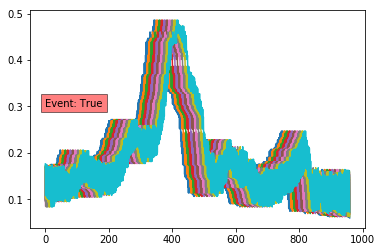

In [50]:
#ax = plt.subplot()
for i in range(0, 10):
    plt.plot(range(len(l[i])),l[i])   

plt.text(0, 0.3, "Event: True",  bbox=dict(facecolor='red', alpha=0.5))
plt.show()

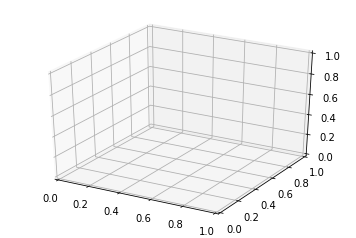

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
for i in range(0, 3):
    X = range(len(l[i]))
    Y = l[i]
    X, Y = np.meshgrid(X, Y)
    Z = range(len(l[i]))
    #X, Z = np.meshgrid(X, Z)
    

In [139]:
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

#df= pd.read_csv('data/finalData/1512.csv')
#eventDf = df['out']
#df= df.drop('out', axis=1)
#dataList = df.values 
#print(eventDf)

In [14]:
sites = [#{'site':'BARC',                       'lat':19.0436,  'lng':72.9197, 'srNo':},
         {'site':'Aggarwal College Ballabgarh', 'lat':28.3317,  'lng':77.3344, 'srNo': 1613},
         {'site':'Gauhati University',          'lat':26.1551,  'lng':91.6627, 'srNo': 1629},
         {'site':'GZRSC, Aizawl',               'lat':23.7398,  'lng':92.7223, 'srNo': 1617},
         #{'site':'IIG Vizag',                  'lat':17.68,    'lng':83.32,   'srNo':},
         {'site':'IOP Bhubaneshwar',            'lat':20.3091,  'lng':85.8309, 'srNo': 1631},
         {'site':'Kashmir University',          'lat':34.12796, 'lng':74.8365, 'srNo': 1622},
         {'site':'Manipur University',          'lat':24.7507,  'lng':93.9291, 'srNo': 1612},
         {'site':'Mizoram University',          'lat':23.735,   'lng':92.6671, 'srNo': 1614},
         {'site':'Nagaland University',         'lat':25.7247,  'lng':94.0955, 'srNo': 1615},
         {'site':'NEHU Shillong',               'lat':25.6089,  'lng':91.8999, 'srNo': 1630},
         {'site':'NIT Rourkela',                'lat':22.2533,  'lng':84.9011, 'srNo': 1601},
         {'site':'SGRC Shillong',               'lat':25.61,    'lng':91.896,  'srNo': 1512},
         {'site':'Silchar Assam',               'lat':24.6919,  'lng':92.7503, 'srNo': 1607},
         {'site':'SINP Kolkata',                'lat':22.5997,  'lng':88.42,   'srNo': 1627},
         {'site':'IIT Roorkee',                 'lat':29.8649,  'lng':77.8966, 'srNo': 1610},
        ]

In [15]:
def animate(i):
    if not i % 100:
        print(i)
    y = dataList[dlen-i]
    line.set_data(x, y)
    event = eventDf[dlen-i]
    if eventDf[dlen-i]:
        text.set_text("Event: {0}".format('True'))
        text.set_bbox(dict(facecolor='red', alpha=0.5))
    else:
        text.set_text("Event: {0}".format('False'))
        text.set_bbox(dict(facecolor='blue', alpha=0.5))
    return (line, text,)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
0
100
200
300
400
500
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
1100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
0
100
200
300
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
0
100
200
30

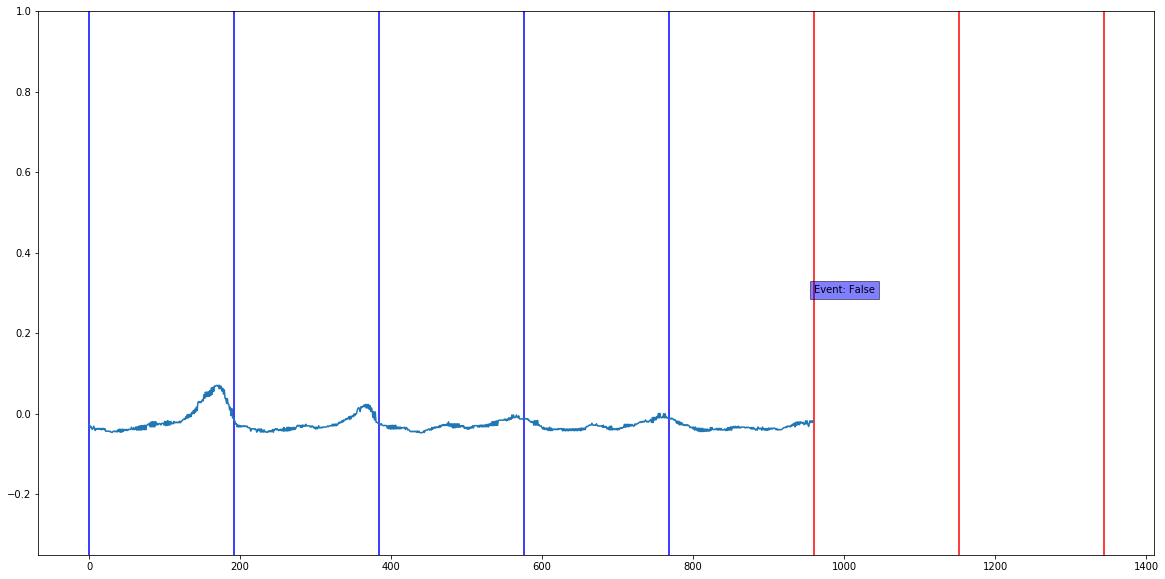

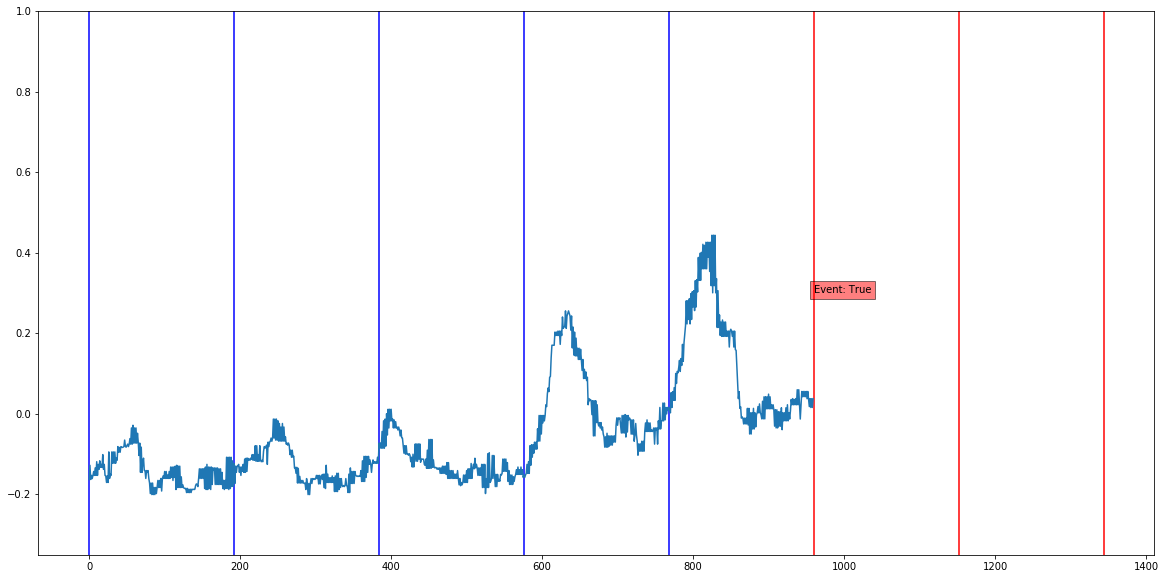

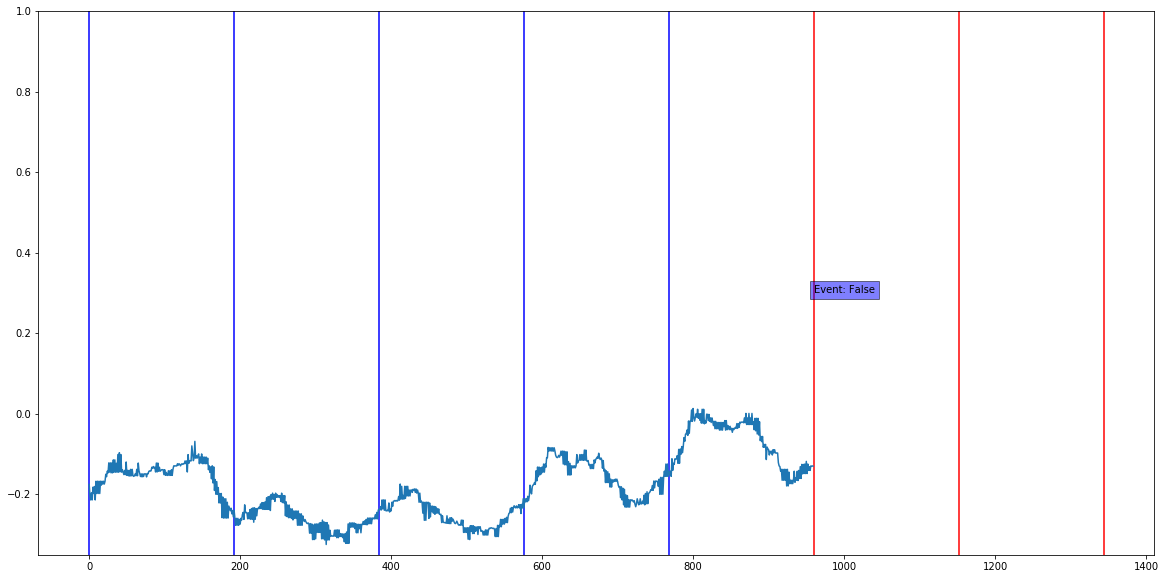

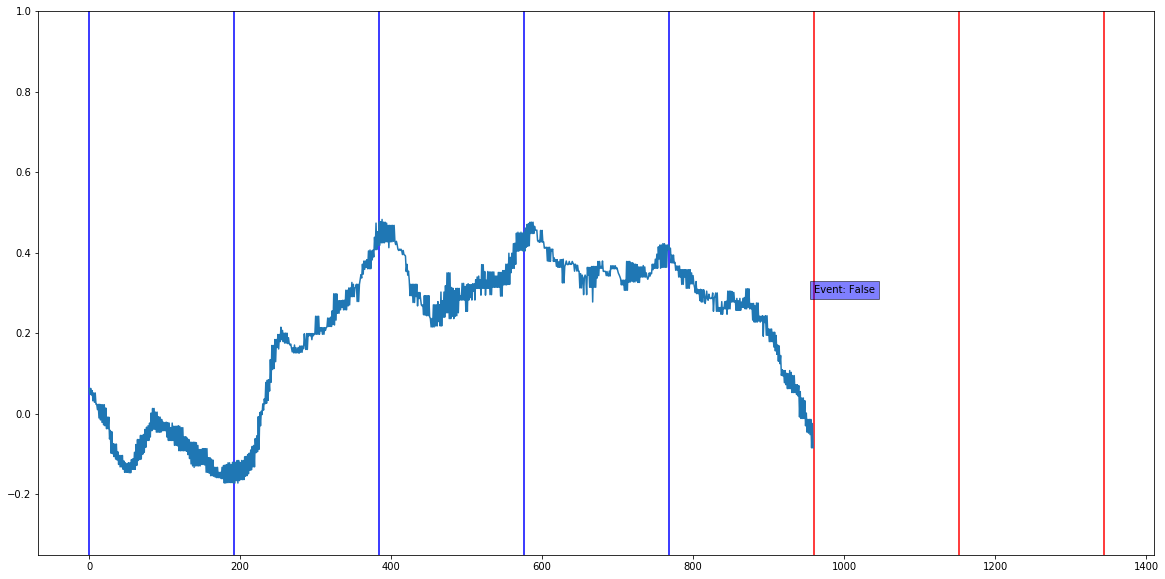

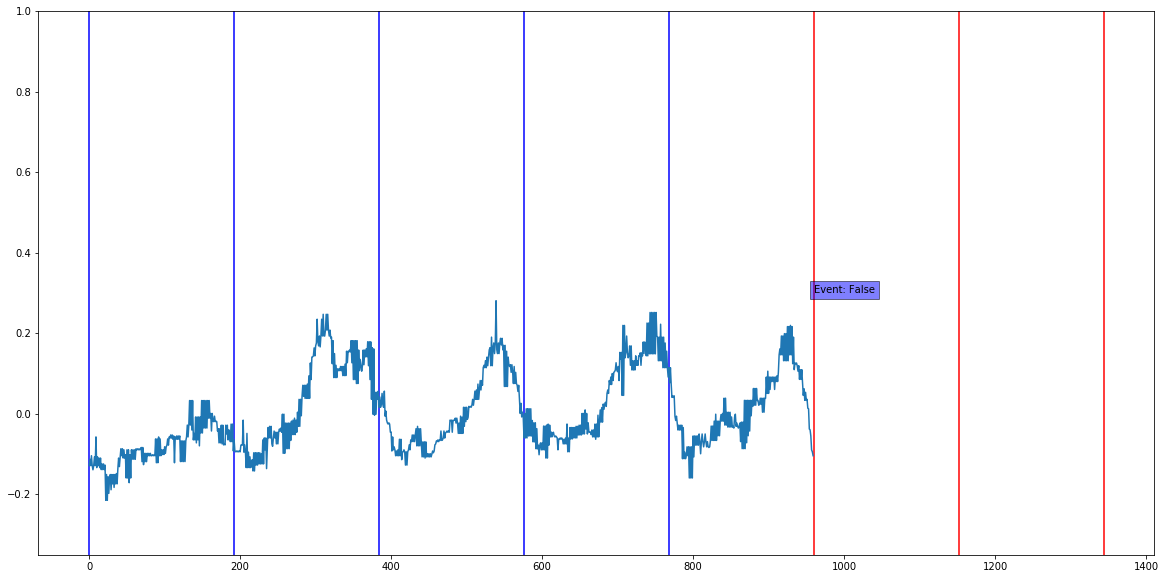

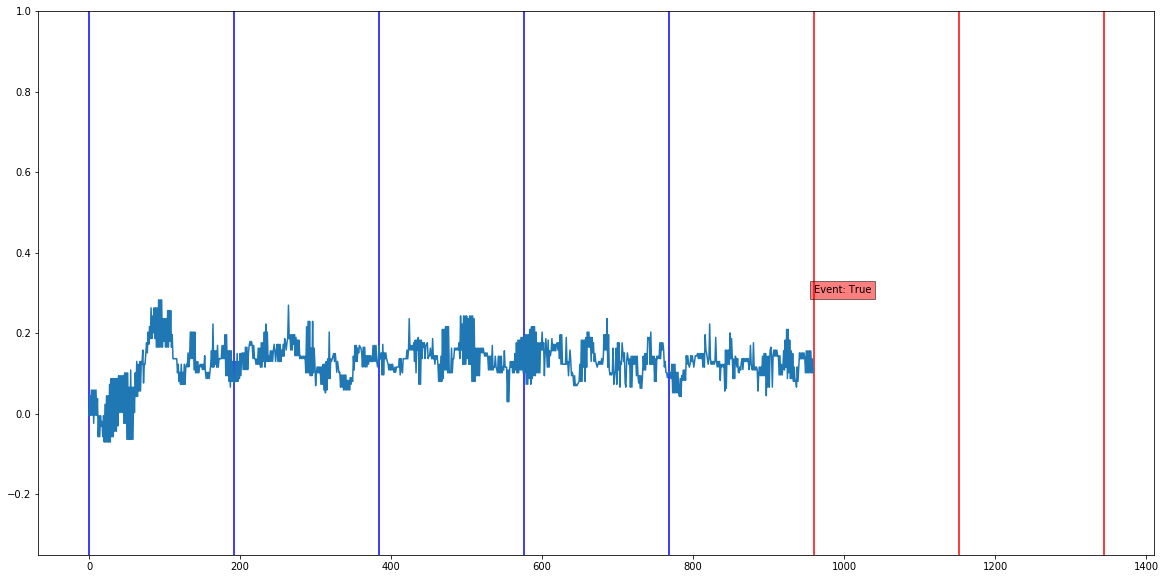

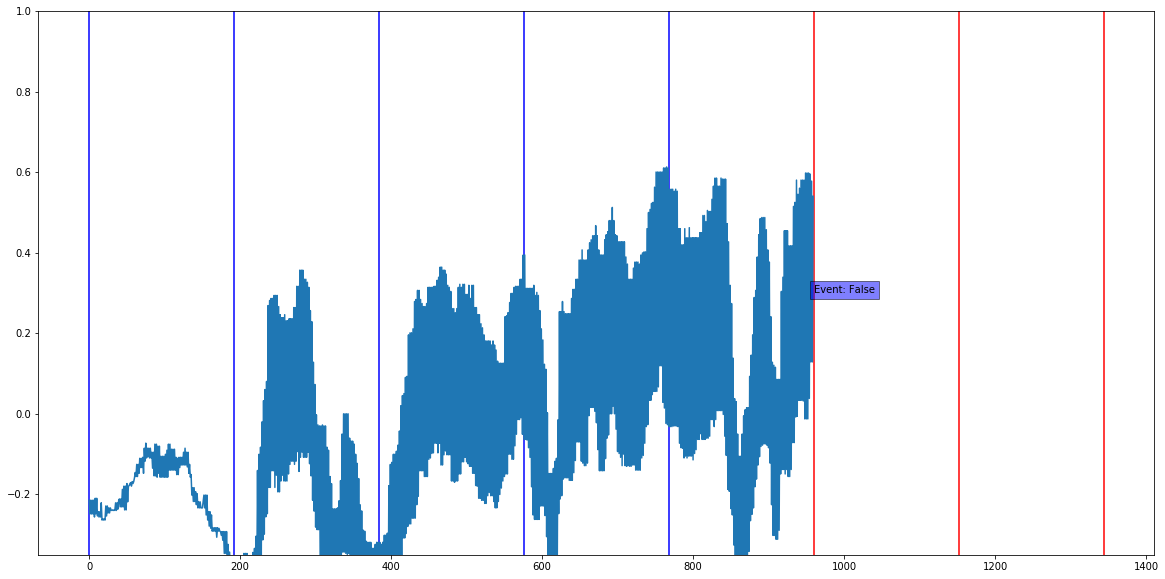

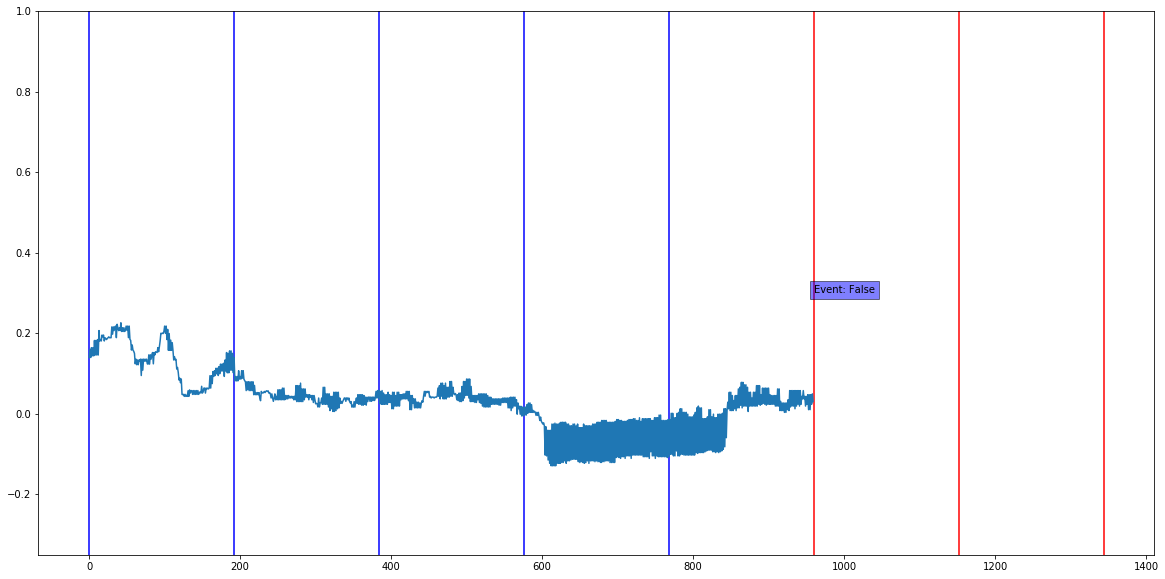

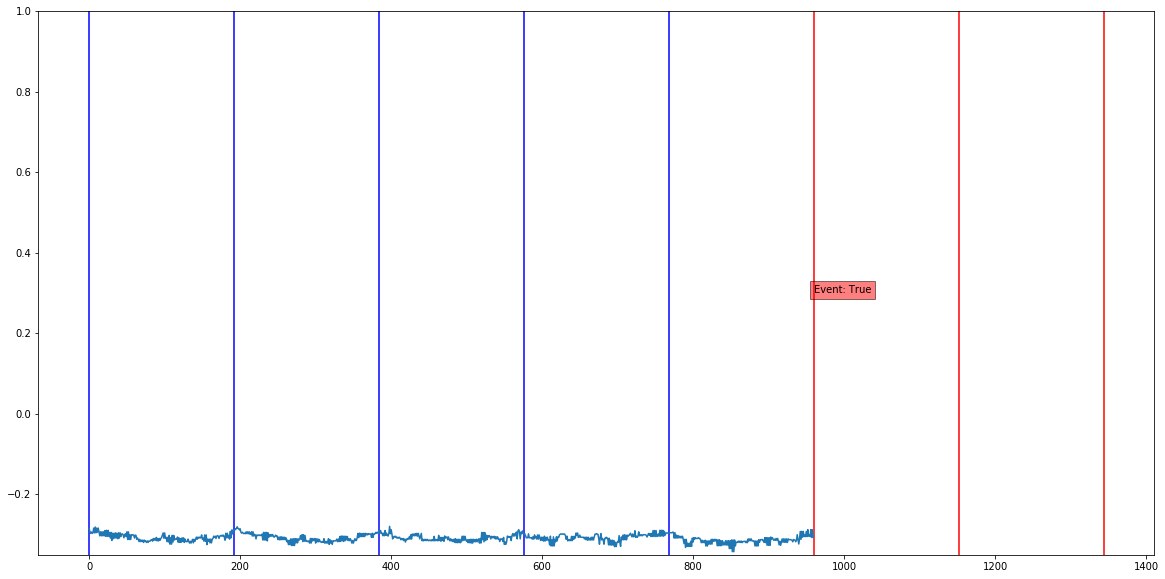

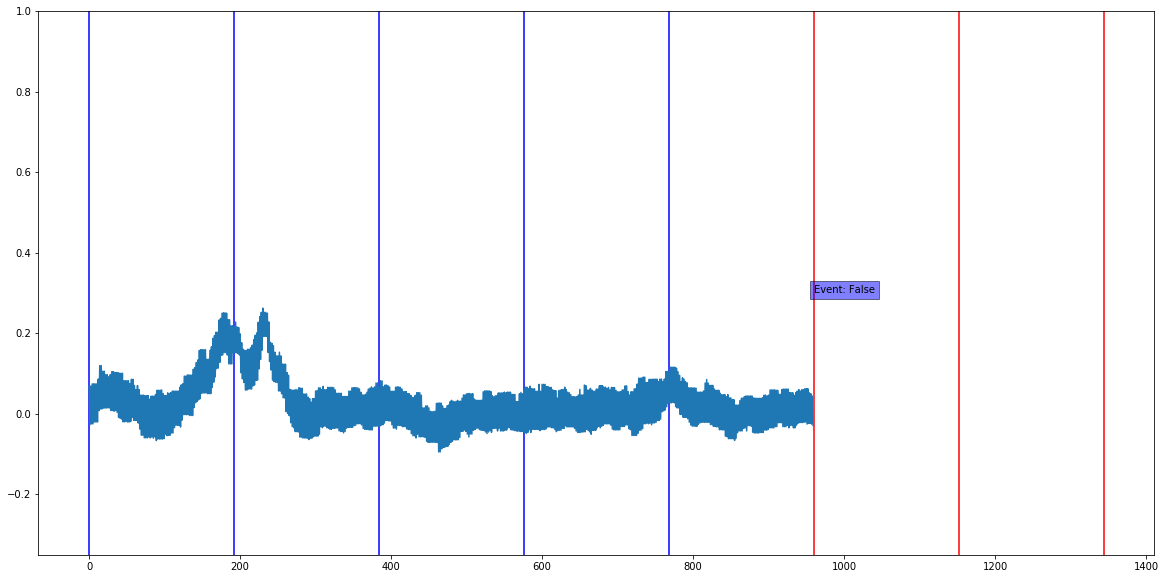

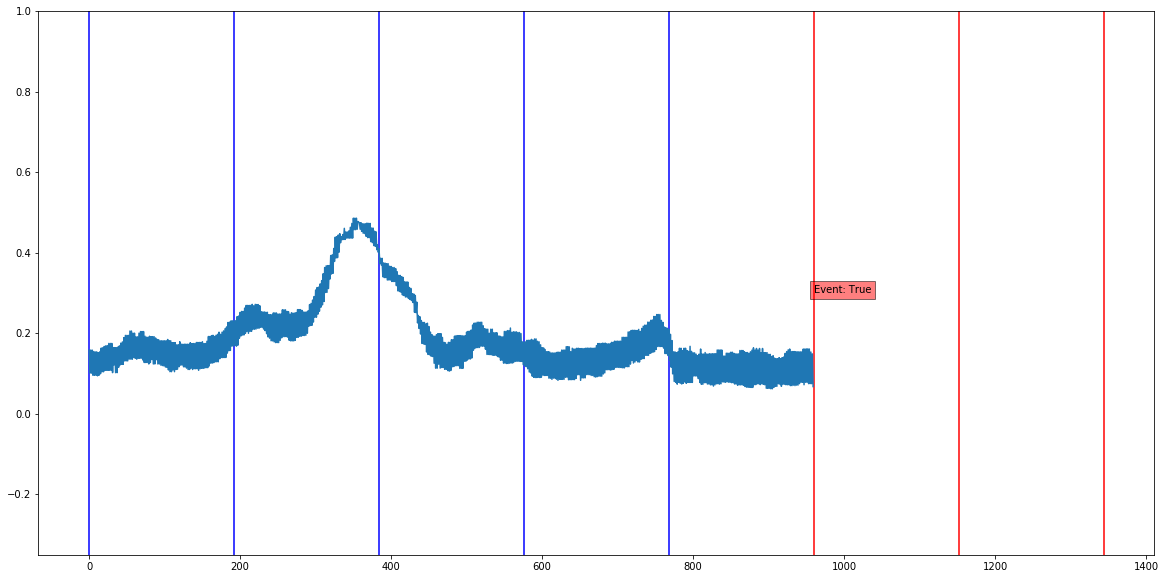

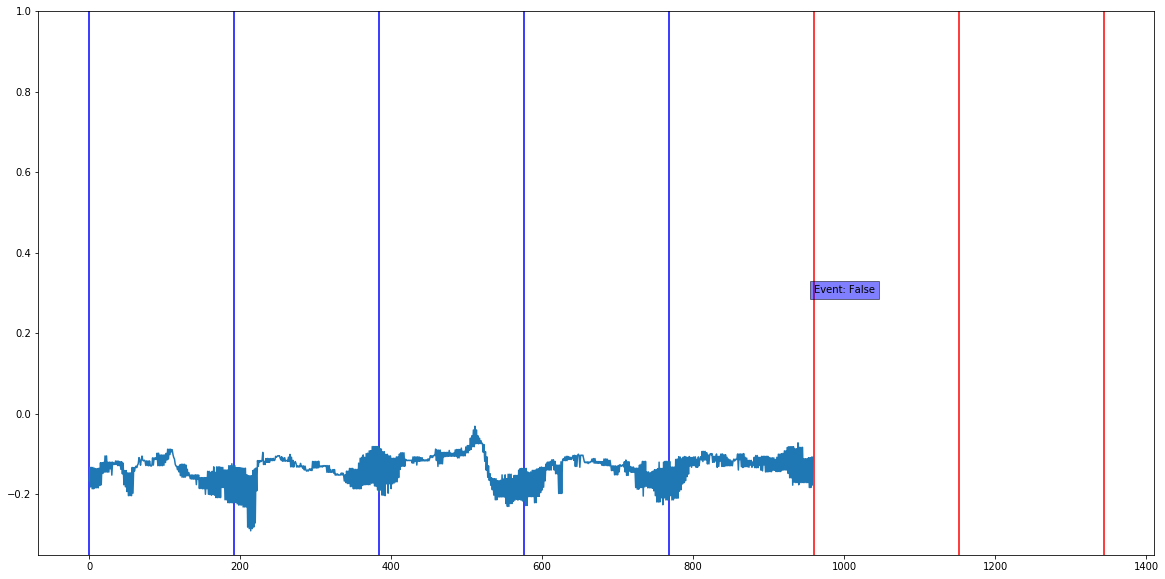

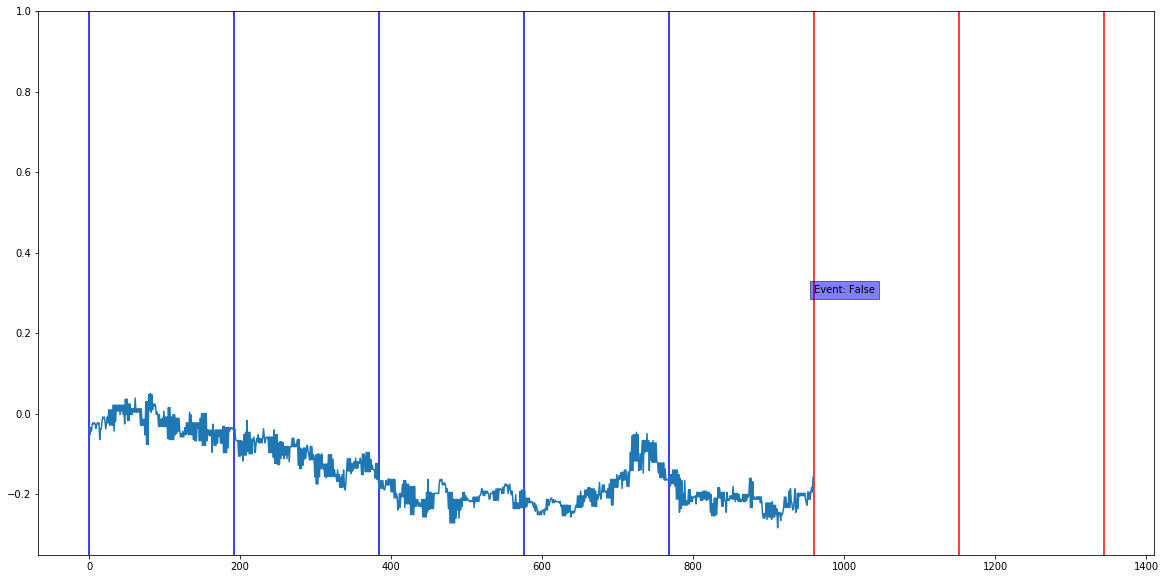

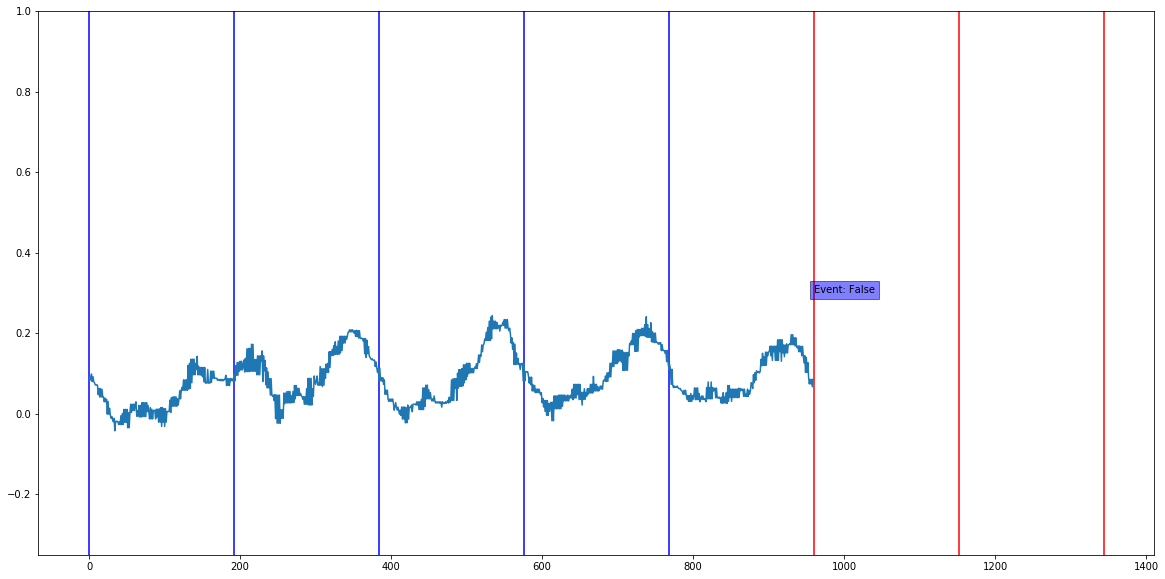

In [17]:
for site in sites:
    selectedSite = site['srNo']  
    fileName = 'data/finalData/'+str(selectedSite)+'.csv'
    df = pd.read_csv('data/finalData/'+str(selectedSite)+'.csv')
    eventDf = df['out']
    df= df.drop('out', axis=1)
    dataList = df.values 
    length = len(dataList[0])
    dlen = len(dataList)-1
    #dlen = 100

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_ylim((-0.35, 1))
    for i in range(5):
        ax.axvline(x=192*i, color='blue')
    for i in range(5, 8):
        ax.axvline(x=192*i, color='red')
    
    x = range(length)
    y = dataList[0]
    line, = ax.plot(x, y)
#text = ax.text(0, 0.3, "Event: True",  bbox=dict(facecolor='white', alpha=0.5))
    text = ax.text(192*5, 0.3, "")

    def init():    
        line.set_data([], [])
        text = ax.text(192*5, 0.3, "")
        
        return (line, text,)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=dlen, interval=20, blit=True)
    anim.save('anim'+str(selectedSite)+'.mp4')
    #HTML(anim.to_html5_video())

In [27]:
def animateGraph(fileName):
    df = pd.read_csv(fileName)
    eventDf = df['out']
    predDf = df['pred']
    df= df.drop('out', axis=1)
    df= df.drop('pred', axis=1)
    dataList = df.values 
    length = len(dataList[0])
    dlen = len(dataList)-1
    #dlen = 100
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_ylim((-0.2, 1))
    for i in range(5):
        ax.axvline(x=192*i, color='blue')
    for i in range(5, 8):
        ax.axvline(x=192*i, color='red')

    x = range(length)
    y = dataList[0]
    line, = ax.plot(x, y)
    #text = ax.text(0, 0.3, "Event: True",  bbox=dict(facecolor='white', alpha=0.5))
    eventTxt = ax.text(192*5, 0.3, "")
    predTxt = ax.text(192*5, 0.2, "")

    def init():    
        line.set_data([], [])
        eventTxt = ax.text(192*5, 0.3, "")
        predTxt = ax.text(192*5, 0.2, "")
        return (line, eventTxt, predTxt, )

    def animate(i):
        if not i % 100:
            print(i)
        y = dataList[dlen-i]
        line.set_data(x, y)
        if eventDf[dlen-i]:
            eventTxt.set_text("Event: {0}".format('True'))
            eventTxt.set_bbox(dict(facecolor='red', alpha=0.5))
        else:
            eventTxt.set_text("Event: {0}".format('False'))
            eventTxt.set_bbox(dict(facecolor='blue', alpha=0.5))
        if predDf[dlen-i]:
            predTxt.set_text("Prediction: {0}".format('True'))
            predTxt.set_bbox(dict(facecolor='red', alpha=0.5))
        else:
            predTxt.set_text("Prediction: {0}".format('False'))
            predTxt.set_bbox(dict(facecolor='blue', alpha=0.5))
        return (line, eventTxt, predTxt, )

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=dlen, interval=20, blit=True)
    anim.save(fileName + '.mp4')
    #HTML(anim.to_html5_video())
    animateGraph('./data/finalDataWithPred/1612.csv')

In [62]:
len(dataList[0])/5

192.0

'/home/abhishek/2018/trainee/eventPredictor'